![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/Spark%20v2.7.6%20Notebooks/3.Clinical_Entity_Resolvers.ipynb)

# Clinical Entity Resolvers

## Colab Setup

In [ ]:
import json

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

In [ ]:
%%capture
for k,v in license_keys.items(): 
    %set_env $k=$v

!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/jsl_colab_setup.sh
!bash jsl_colab_setup.sh -p 2.4.4

! pip install spark-nlp-display

In [ ]:
import json
import os
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
import sparknlp_jsl
import sparknlp

from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 2.7.4
Spark NLP_JSL Version : 2.7.6


In [ ]:
spark

# Clinical Resolvers

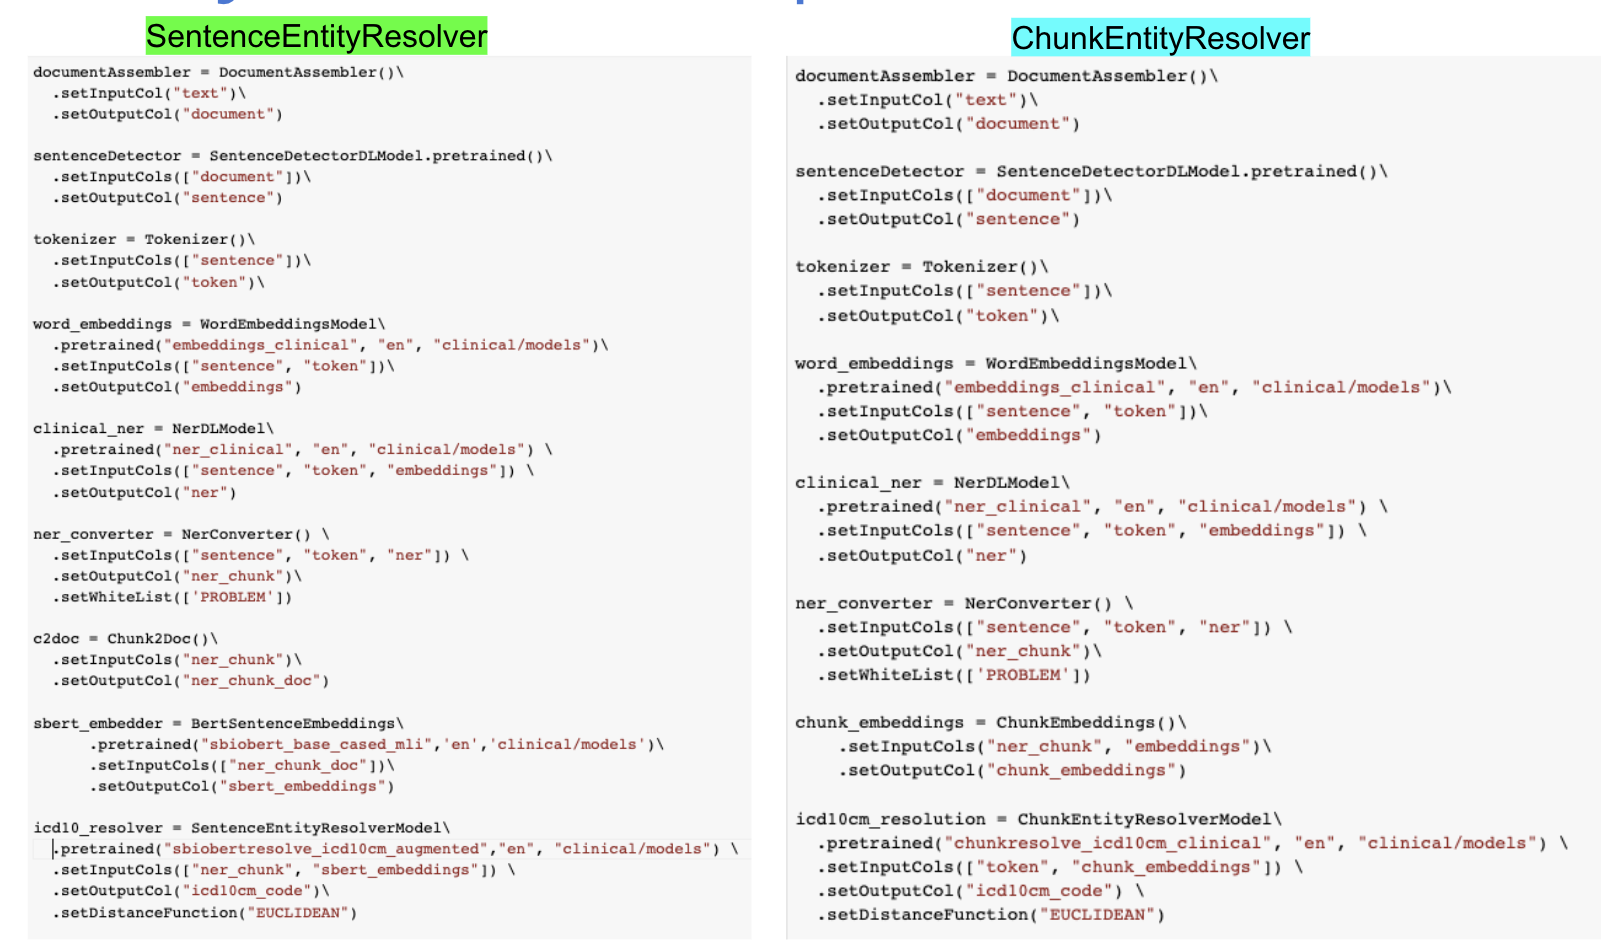

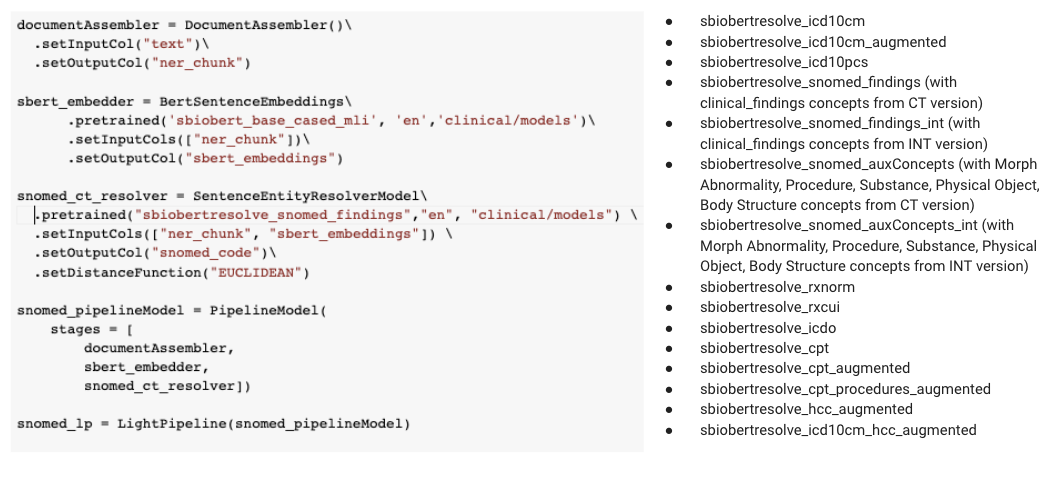

## Entity Resolvers for ICD-10

### Clinical NER Pipeline creation

In [ ]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP

documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

# Sentence Detector DL annotator, processes various sentences per line

sentenceDetectorDL = SentenceDetectorDLModel\
      .pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
      .setInputCols(["document"]) \
      .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP

tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("raw_token")

# Tokenizer splits words in a relevant format for NLP
stopwords = StopWordsCleaner()\
      .setInputCols(["raw_token"])\
      .setOutputCol("token")
  

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 363.9 KB
[OK!]


The fourth annotator in the pipeline is 'WordEmbeddingsModel'. We will download a pretrained model available from "clinical/models" named 'embeddings_clinical'.

When running this cell your are advised to be patient.

First time you call this pretrained model it needs to be downloaded in your local.

The model size is about will download the embeddings_clinical corpus it takes a while.

The size is about 1.7Gb and will be saved typically in your home folder as

`~HOMEFOLDER/cached_models/embeddings_clinical_en_2.0.2_2.4_1558454742956`

Next times you call it the model is loaded from your cached copy but even in that case it needs to be indexed each time so expect waiting up to 5 minutes (depending on your machine)

In [ ]:
# WordEmbeddingsModel pretrained "embeddings_clinical" includes a model of 1.7Gb that needs to be downloaded

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")
  

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


The fifth and final annotator in our NER pipeline is the pretrained `ner_clinical` NerDLModel avaliable from "clinical/models". It requires as input the "sentence", "token" and "embeddings" (clinical embeddings pretrained model) and will classify each token in four categories:

- `PROBLEM`: for patient problems

- `TEST`: for tests, labs, etc.

- `TREATMENT`: for treatments, medicines, etc.

- `OTHER`: for the rest of tokens.

In order to split those identified NER that are consecutive, the B prefix (as B-PROBLEM) will be used at the first token of each NER. The I prefix (as I-PROBLEM) will be used for the rest of tokens inside the NER.

In [ ]:
# Named Entity Recognition for clinical concepts.

clinical_ner = NerDLModel.pretrained("ner_clinical", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

ner_converter = NerConverter() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")


ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


### Define the NER pipeline

Now we will define the actual pipeline that puts together the annotators we have created.

In [ ]:
# Build up the pipeline

pipeline_ner = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetectorDL,
        tokenizer,
        stopwords,
        word_embeddings,
        clinical_ner,
        ner_converter
  ])

### Create a SparkDataFrame with the content

Now we will create a sample Spark dataframe with our clinical note example.

In this example we are working over a unique clinical note. In production environments a table with several of those clinical notes could be distributed in a cluster and be run in large scale systems.

In [ ]:
clinical_note = (
    'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years '
    'prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior '
    'episode of HTG-induced pancreatitis three years prior to presentation, associated '
    'with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, '
    'presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting. '
    'Two weeks prior to presentation, she was treated with a five-day course of amoxicillin '
    'for a respiratory tract infection. She was on metformin, glipizide, and dapagliflozin '
    'for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months '
    'at the time of presentation. Physical examination on presentation was significant for dry oral mucosa; '
    'significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent '
    'laboratory findings on admission were: serum glucose 111 mg/dl, bicarbonate 18 mmol/l, anion gap 20, '
    'creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, glycated hemoglobin (HbA1c) '
    '10%, and venous pH 7.27. Serum lipase was normal at 43 U/L. Serum acetone levels could not be assessed '
    'as blood samples kept hemolyzing due to significant lipemia. The patient was initially admitted for '
    'starvation ketosis, as she reported poor oral intake for three days prior to admission. However, '
    'serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL, the anion gap '
    'was still elevated at 21, serum bicarbonate was 16 mmol/L, triglyceride level peaked at 2050 mg/dL, and '
    'lipase was 52 U/L. The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - '
    'the original sample was centrifuged and the chylomicron layer removed prior to analysis due to '
    'interference from turbidity caused by lipemia again. The patient was treated with an insulin drip '
    'for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL, within '
    '24 hours. Her euDKA was thought to be precipitated by her respiratory tract infection in the setting '
    'of SGLT2 inhibitor use. The patient was seen by the endocrinology service and she was discharged on '
    '40 units of insulin glargine at night, 12 units of insulin lispro with meals, and metformin 1000 mg '
    'two times a day. It was determined that all SGLT2 inhibitors should be discontinued indefinitely. She '
    'had close follow-up with endocrinology post discharge.'
)

data_ner = spark.createDataFrame([[clinical_note]]).toDF("text")

In [ ]:
data_ner.show(truncate = 100)


+----------------------------------------------------------------------------------------------------+
|                                                                                                text|
+----------------------------------------------------------------------------------------------------+
|A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior ...|
+----------------------------------------------------------------------------------------------------+



### Transform / annotate the clinical note using the model.

In order to process the data with the new created model we have two options.

The first one would be to use the model to transform our clinical note by the command:

`output = model_ner.transform(data_ner)`

That would save in a Spakr DataFrame (output) the resuls of running the model over the clinical note.

However for small tests like this or for real-time request a LightPipelines is a simpler way of managing the data. It will return a dictionary (instead of a Spark DataFrame) with the results of the transformation

We will create a light_pipeline_ner using our model_ner and then will annotate the clinical_note using this light_pipeline.

In [ ]:
model = pipeline_ner.fit(data_ner)

light_pipeline = LightPipeline(model)

light_data = light_pipeline.annotate(clinical_note)

Now we have a dictionaty (light_data_ner) that contains the results of running the NER pipeline over our clinical note.

It contains the original document:

In [ ]:
light_data['document'][0][0:100]


'A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to '

In [ ]:
print("Number of sentences: {}".format(len(light_data['sentence'])))
print("")
for i in range(15):
    print("Sentence {}: {}".format(i, light_data['sentence'][i]))

Number of sentences: 16

Sentence 0: A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, associated with an acute hepatitis, and obesity with a body mass index (BMI) of 33.5 kg/m2, presented with a one-week history of polyuria, polydipsia, poor appetite, and vomiting.
Sentence 1: Two weeks prior to presentation, she was treated with a five-day course of amoxicillin for a respiratory tract infection.
Sentence 2: She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG.
Sentence 3: She had been on dapagliflozin for six months at the time of presentation.
Sentence 4: Physical examination on presentation was significant for dry oral mucosa; significantly, her abdominal examination was benign with no tenderness, guarding, or rigidity.
Sentence 5: Pertinent la

In [ ]:
print("Number of tokens: {}".format(len(light_data['token'])))
print("")
for i in range(25):
    print("Token {}: {} ({})".format(i, light_data['token'][i], light_data['ner'][i]))
print("...")

Number of tokens: 299

Token 0: 28-year-old (O)
Token 1: female (O)
Token 2: history (O)
Token 3: gestational (B-PROBLEM)
Token 4: diabetes (I-PROBLEM)
Token 5: mellitus (I-PROBLEM)
Token 6: diagnosed (O)
Token 7: eight (O)
Token 8: years (O)
Token 9: prior (O)
Token 10: presentation (O)
Token 11: subsequent (O)
Token 12: type (B-PROBLEM)
Token 13: two (I-PROBLEM)
Token 14: diabetes (I-PROBLEM)
Token 15: mellitus (I-PROBLEM)
Token 16: ( (O)
Token 17: T2DM (B-PROBLEM)
Token 18: ), (O)
Token 19: one (B-PROBLEM)
Token 20: prior (I-PROBLEM)
Token 21: episode (I-PROBLEM)
Token 22: HTG-induced (I-PROBLEM)
Token 23: pancreatitis (I-PROBLEM)
Token 24: three (O)
...


Lets apply some HTML formating to see the results of the pipeline in a nicer layout:



In [ ]:
light_result = light_pipeline.fullAnnotate(clinical_note)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

#visualiser.display(light_result[0], label_col='entities', document_col='document')

# Change color of an entity label

visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
visualiser.display(light_result[0], label_col='ner_chunk')

# Set label filter

# visualiser.display(light_result, label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

##  ICD10 background info

ICD-10-CM vs. ICD-10-PCS

With the transition to ICD-10, in the United States, ICD-9 codes are segmented into ICD-10-CM and ICD-10-PCS codes. **The "CM" in ICD-10-CM codes stands for clinical modification**; ICD-10-CM codes were developed by the Centers for Disease Control and Prevention in conjunction with the National Center for Health Statistics (NCHS), for outpatient medical coding and reporting in the United States, as published by the World Health Organization (WHO).

**The "PCS" in ICD-10-PCS codes stands for the procedural classification system**. ICD-10-PCS is a completely separate medical coding system from ICD-10-CM, containing an additional 87,000 codes for use ONLY in United States inpatient, hospital settings. The procedure classification system (ICD-10-PCS) was developed by the Centers for Medicare and Medicaid Services (CMS) in conjunction with 3M Health Information Management (HIM).

ICD-10-CM codes add increased specificity to their ICD-9 predecessors, growing to five times the number of codes as the present system; a total of 68,000 clinical modification diagnosis codes. ICD-10-CM codes provide the ability to track and reveal more information about the quality of healthcare, allowing healthcare providers to better understand medical complications, better design treatment and care, and better comprehend and determine the outcome of care.

ICD-10-PCS is used only for inpatient, hospital settings in the United States, and is meant to replace volume 3 of ICD-9 for facility reporting of inpatient procedures. Due to the rapid and constant state of flux in medical procedures and technology, ICD-10-PCS was developed to accommodate the changing landscape. Common procedures, lab tests, and educational sessions that are not unique to the inpatient, hospital setting have been omitted from ICD-10-PCS.

ICD-10 is confusing enough when you’re trying to digest the differences between ICD-9 and ICD-10, but there are also different types of ICD-10 codes that providers should be aware of.


**Primary difference between ICD-10-CM and ICD-10-PCS**

When most people talk about ICD-10, they are referring to ICD-10CM. This is the code set for diagnosis coding and is used for all healthcare settings in the United States. ICD-10PCS, on the other hand, is used in hospital inpatient settings for inpatient procedure coding.

ICD-10-CM breakdown

- Approximately 68,000 codes
- 3–7 alphanumeric characters
- Facilitates timely processing of claims


ICD-10-PCS breakdown

- Will replace ICD-9-CM for hospital inpatient use only. 
- ICD-10-PCS will not replace CPT codes used by physicians. According to HealthCare Information Management, Inc. (HCIM), “Its only intention is to identify inpatient facility services in a way not directly related to physician work, but directed towards allocation of hospital services.”

- 7 alphanumeric characters

ICD-10-PCS is very different from ICD-9-CM procedure coding due to its ability to be more specific and accurate. “This becomes increasingly important when assessing and tracking the quality of medical processes and outcomes, and compiling statistics that are valuable tools for research,” according to HCIM.


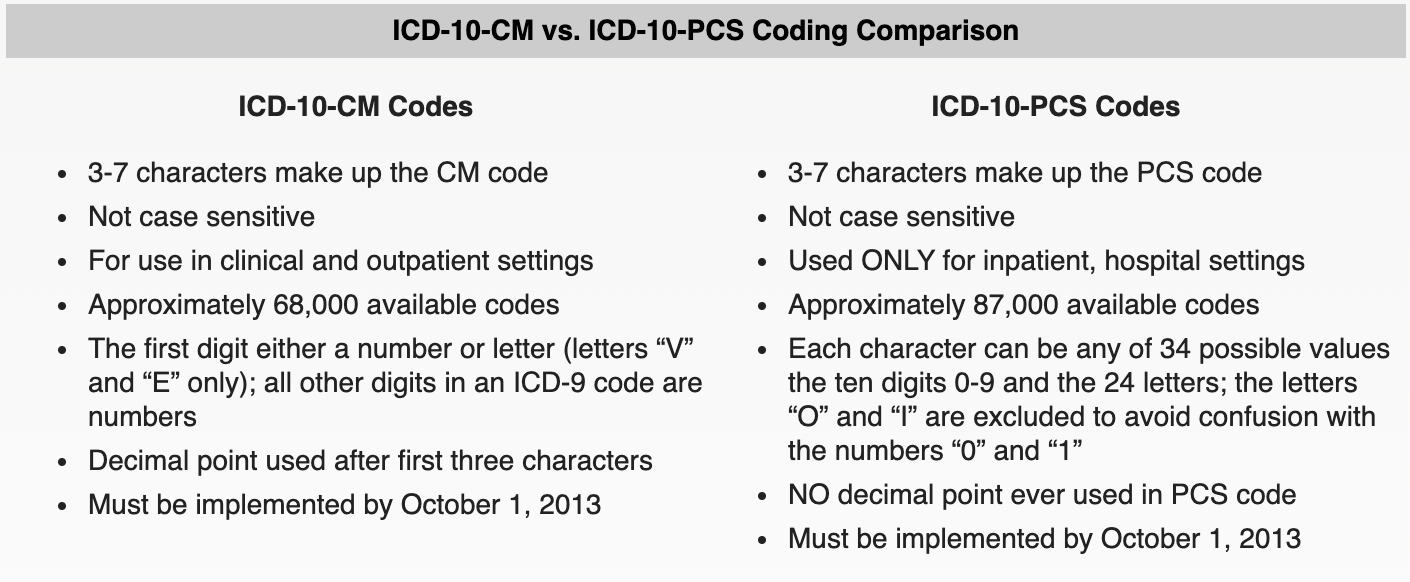

## Chunk Entity Resolver
## ICD10 coding Pipeline creation.

A common NLP problem in biomedical aplications is to identify the presence of clinical entities in a given text. This clinical entities could be diseases, symptoms, drugs, results of clinical investigations or others.

Other than providing the code in the "result" field it provides more metadata about the matching process:

- target_text -> Text to resolve
- resolved_text -> Best match text
- confidence -> Relative confidence for the top match (distance to probability)
- confidence_ratio -> Relative confidence for the top match. TopMatchConfidence / SecondMatchConfidence
- alternative_codes -> List of other plausible codes (in the KNN neighborhood)
- alternative_confidence_ratios -> Rest of confidence ratios
- all_k_results -> All resolved codes for metrics calculation purposes
- sentence -> SentenceId
- chunk -> ChunkId

We will now create a new pipeline that from each of these problems will try to assign an ICD10 base on the content, the wordembeddings and some pretrained models for ICD10 annotation.

The architecture of this new pipeline will be as follows:

- DocumentAssembler (text -> document)

- SentenceDetector (document -> sentence)

- Tokenizer (sentence -> token)

- WordEmbeddingsModel ([sentence, token] -> embeddings)

- NerDLModel ([sentence, token, embeddings] -> ner)

- NerConverter (["sentence, token, ner] -> ner_chunk

- ChunkTokenizer (ner_chunk -> ner_chunk_tokenized)

- ICD10CMEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

- ICD10PCSEntityResolverModel ([ner_chunk_tokenized, embeddings] -> resolution)

So from a text we end having a list of Named Entities (ner_chunk) and their ICD10 codes (resolution)

Most of the annotators in this pipeline have been already created for the previous pipeline, but we need to create four additional annotators: NerConverter, ChunkEmbeddigns, EntityResolverModel for ICD10CM and EntityResolverModel for ICD10PCS.

Now we define the new pipeline




In [ ]:
# Named Entity Recognition concepts parser, transforms entities into CHUNKS (required for next step: assertion status)

ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['PROBLEM'])
    #\.setPreservePosition(False)

chunk_embeddings = ChunkEmbeddings()\
    .setInputCols("ner_chunk", "embeddings")\
    .setOutputCol("chunk_embeddings")

# ICD resolution model

icd10cm_resolution = ChunkEntityResolverModel.pretrained("chunkresolve_icd10cm_clinical", "en", "clinical/models") \
    .setInputCols(["token", "chunk_embeddings"]) \
    .setOutputCol("icd10cm_code") \
    .setDistanceFunction("COSINE") \
    .setNeighbours(5)

# .setDistanceFunction("EUCLIDEAN")

chunkresolve_icd10cm_clinical download started this may take some time.
Approximate size to download 166.3 MB
[OK!]


`setPreservePosition(True)` takes exactly the original indices (under some tokenization conditions it might include some undesires chars like `")","]"...)`

`setPreservePosition(False)` takes adjusted indices based on substring indexingOf the first (for begin) and last (for end) tokens

also with internal we can use the `greedyMode` which will marge consecutive entities of same type regardless of b-boundaries

In [ ]:
pipeline_icd10 = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetectorDL,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner,
    ner_converter,
    chunk_embeddings,
    icd10cm_resolution
  ])

model_icd10 = pipeline_icd10.fit(data_ner)


In [ ]:
light_pipeline_icd10 = LightPipeline(model_icd10)


In [ ]:
full_light_result = light_pipeline_icd10.fullAnnotate('A 28-year-old female with a history of gestational diabetes mellitus')

full_light_result[0]['icd10cm_code']

[Annotation(entity, 39, 67, P702, {'chunk': '0', 'all_k_results': 'P702:::E1165:::E232', 'all_k_distances': '0.7542:::0.9040:::1.1832', 'confidence': '0.3981', 'all_k_cosine_distances': '0.0796:::0.1034:::0.1886', 'all_k_resolutions': 'Neonatal diabetes mellitus:::Type 2 diabetes mellitus with hyperglycemia:::Diabetes insipidus', 'target_text': 'gestational diabetes mellitus', 'all_k_aux_labels': '', 'token': 'gestational diabetes mellitus', 'resolved_text': 'Neonatal diabetes mellitus', 'all_k_confidences': '0.3981:::0.3427:::0.2592', 'distance': '0.7542', 'sentence': '0'})]

In [ ]:
full_light_result[0]["ner_chunk"]

[Annotation(chunk, 39, 67, gestational diabetes mellitus, {'entity': 'PROBLEM', 'sentence': '0', 'chunk': '0', 'confidence': '0.87929994'})]

In [ ]:
from sparknlp_display import EntityResolverVisualizer

vis = EntityResolverVisualizer()

# Change color of an entity label
vis.set_label_colors({'PROBLEM':'#008080'})

vis.display(full_light_result[0], 'ner_chunk', 'icd10cm_code')


In [ ]:
import pandas as pd

light_result = light_pipeline_icd10.annotate(clinical_note)

df = pd.DataFrame(list(zip(light_result['ner_chunk'], light_result['icd10cm_code'])),
                  columns = ['Problem','ICD10-CM-Code'])

In [ ]:
df.head(20)

,Problem,ICD10-CM-Code
0,gestational diabetes mellitus,P702
1,type two diabetes mellitus,E1142
2,T2DM,E1121
3,one prior episode of HTG-induced pancreatitis,K860
4,associated with an acute hepatitis,B172
5,obesity with a body mass,E661
6,polyuria,R358
7,polydipsia,R631
8,poor appetite,R630
9,vomiting,R1114


In [ ]:
def get_codes (light_model, code, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][code]):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolutions.append(code.metadata['all_k_resolutions'])
      
  import pandas as pd

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'code':codes,
                    'resolutions':resolutions})

  return df


In [ ]:
df = get_codes (light_pipeline_icd10, 'icd10cm_code', clinical_note)

df

,chunks,begin,end,code,resolutions
0,gestational diabetes mellitus,39,67,P702,Neonatal diabetes mellitus:::Type 2 diabetes m...
1,type two diabetes mellitus,128,153,E1142,Type 2 diabetes mellitus with diabetic polyneu...
2,T2DM,156,159,E1121,Type 2 diabetes mellitus with diabetic nephrop...
3,one prior episode of HTG-induced pancreatitis,163,207,K860,Alcohol-induced chronic pancreatitis:::Manic e...
4,associated with an acute hepatitis,244,277,B172,"Acute hepatitis E:::Acute viral hepatitis, uns..."
5,obesity with a body mass,284,307,E661,Drug-induced obesity:::Body mass index (BMI) 2...
6,polyuria,373,380,R358,Other polyuria:::Polydipsia:::Generalized edem...
7,polydipsia,383,392,R631,Polydipsia:::Anhedonia:::Galactorrhea
8,poor appetite,395,407,R630,"Anorexia:::Nutritional deficiency, unspecified..."
9,vomiting,414,421,R1114,Bilious vomiting:::Vomiting without nausea:::N...


In [ ]:
text = 'He has a starvation ketosis but nothing found for significant for dry oral mucosa'

df = get_codes(light_pipeline_icd10, 'icd10cm_code', text)

df

,chunks,begin,end,code,resolutions
0,starvation ketosis,9,26,E71121,Propionic acidemia:::Bartter's syndrome:::Hypo...
1,significant for dry oral mucosa,50,80,K136,Irritative hyperplasia of oral mucosa:::Leukop...


## CPT Resolver

The Current Procedural Terminology (CPT) code set is a medical code set maintained by the American Medical Association. The CPT code set describes medical, surgical, and diagnostic services and is designed to communicate uniform information about medical services and procedures among physicians, coders, patients, accreditation organizations, and payers for administrative, financial, and analytical purposes.

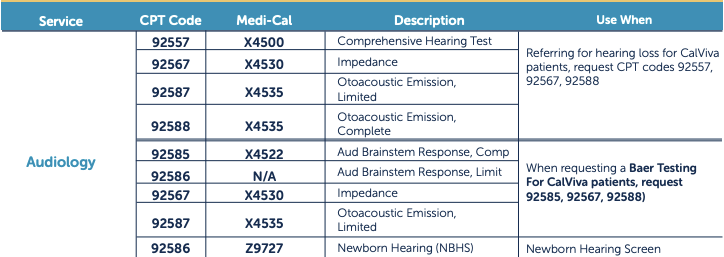

In [ ]:
ner_converter_cpt = NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(['TREATMENT','TEST'])\
    .setPreservePosition(False)

cpt_resolution = ChunkEntityResolverModel.pretrained("chunkresolve_cpt_clinical", "en", "clinical/models") \
    .setInputCols(["token", "chunk_embeddings"]) \
    .setOutputCol("cpt_code") \
    .setDistanceFunction("COSINE") \
    .setNeighbours(5)

pipeline_cpt = Pipeline(
    stages = [
    documentAssembler,
    sentenceDetectorDL,
    tokenizer,
    stopwords,
    word_embeddings,
    clinical_ner,
    ner_converter_cpt,
    chunk_embeddings,
    cpt_resolution
  ])

model_cpt = pipeline_cpt.fit(data_ner)


chunkresolve_cpt_clinical download started this may take some time.
Approximate size to download 16.2 MB
[OK!]


In [ ]:
light_pipeline_cpt = LightPipeline(model_cpt)


In [ ]:
df = get_codes (light_pipeline_cpt, 'cpt_code', 'The patient needs to have a coronary artery bypass but doctor suggests a abdomen CT at first.')

df

,chunks,begin,end,code,resolutions
0,coronary artery bypass,28,49,33535,"Coronary artery bypass, using arterial graft(s..."
1,abdomen CT,73,82,44970,"Laparoscopy, surgical, appendectomy :::Stereot..."


# Sentence Entity Resolver (CPT)

In [ ]:
tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")\

ner_converter_cpt = NerConverterInternal() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")\
      .setWhiteList(['TREATMENT','TEST'])\
      .setPreservePosition(False)

c2doc = Chunk2Doc()\
      .setInputCols("ner_chunk")\
      .setOutputCol("ner_chunk_doc") 

sbert_embedder = BertSentenceEmbeddings\
      .pretrained("sbiobert_base_cased_mli",'en','clinical/models')\
      .setInputCols(["ner_chunk_doc"])\
      .setOutputCol("sbert_embeddings")

cpt_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_cpt_augmented","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("sbert_cpt_code")\
      .setDistanceFunction("EUCLIDEAN")
  
sbert_resolver_pipeline = Pipeline(
    stages = [
        documentAssembler,
        sentenceDetectorDL,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter_cpt,
        c2doc,
        sbert_embedder,
        cpt_resolver])


data_ner = spark.createDataFrame([['sample text']]).toDF("text")

sbert_models = sbert_resolver_pipeline.fit(data_ner)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_cpt_augmented download started this may take some time.
Approximate size to download 139.1 MB
[OK!]


In [ ]:
sbert_light_pipeline_cpt = LightPipeline(sbert_models)

df = get_codes (sbert_light_pipeline_cpt, 'sbert_cpt_code', 'The patient needs to have a coronary artery bypass but doctor suggests an abdomen CT at first.')

df

,chunks,begin,end,code,resolutions
0,a coronary artery bypass,26,49,1006216,Arterial Grafting for Coronary Artery Bypass::...
1,an abdomen CT,71,83,1010526,"Computed tomography, abdomen:::US abdominal sc..."


In [ ]:
df['resolutions'][0]

'Arterial Grafting for Coronary Artery Bypass:::Coronary artery bypass, using arterial graft(s):::Coronary artery graft placement:::Coronary artery graft placement:::Coronary artery graft placement:::Aortic bifurcation bypass graft:::Aortic bifurcation bypass graft:::Procedure on coronary arteries:::Aortoiliac vascular bypass:::Aortoiliac vascular bypass:::Aortoiliac vascular bypass:::Aortoiliac vascular bypass:::Aortoiliac vascular bypass:::Arterial bypass graft:::Arterial bypass graft:::Arterial bypass graft:::Arterial bypass graft:::Coronary artery reconstruction:::Coronary artery reconstruction:::Reimplantation of coronary artery:::Reimplantation of coronary artery'

In [ ]:
df["resolutions"][1]

'Computed tomography, abdomen:::US abdominal scan:::US abdominal scan:::Radiologic examination, abdomen:::Radiologic examination, abdomen:::Computed tomography, abdomen; with contrast material(s):::Magnetic resonance imaging of abdomen:::Magnetic resonance imaging of abdomen:::Computed tomography of abdominal vascular structures:::Procedure on abdomen:::Procedure on abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen:::Endoscopy of abdomen'


### **Warning**: **If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun. **


- sbiobertresolve_icd10cm 
- sbiobertresolve_icd10cm_augmented
- sbiobertresolve_icd10pcs
- sbiobertresolve_snomed_findings (with clinical_findings concepts from CT version)
- sbiobertresolve_snomed_findings_int  (with clinical_findings concepts from INT version)
- sbiobertresolve_snomed_auxConcepts (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from CT version)
- sbiobertresolve_snomed_auxConcepts_int  (with Morph Abnormality, Procedure, Substance, Physical Object, Body Structure concepts from INT version)
- sbiobertresolve_rxnorm
- sbiobertresolve_rxcui
- sbiobertresolve_icdo
- sbiobertresolve_cpt

# Sentence Entity Resolver (RxNorm)

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sbert_embeddings"]) \
      .setOutputCol("rxnorm_code")\
      .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = LightPipeline(rxnorm_pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 810.7 MB
[OK!]


In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)

def get_codes (lp, text, vocab='rxnorm_code'):
    
    full_light_result = lp.fullAnnotate(text)

    chunks = []
    codes = []
    begin = []
    end = []
    resolutions=[]
    entities=[]
    all_distances =[]
    all_codes=[]
    
    for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][vocab]):
            
        begin.append(chunk.begin)
        end.append(chunk.end)
        chunks.append(chunk.result)
        entities.append(chunk.metadata['entity']) 
        codes.append(code.result) 
        all_codes.append(code.metadata['all_k_results'].split(':::'))
        resolutions.append(code.metadata['all_k_resolutions'].split(':::'))
        all_distances.append(code.metadata['all_k_distances'].split(':::'))

    df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 'entity':entities,
                    'code':codes,'all_codes':all_codes, 
                    'resolutions':resolutions, 'all_distances':all_distances})

    
    return df



In [ ]:
text = 'metformin 100 mg'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 38.1 ms, sys: 11.2 ms, total: 49.3 ms
Wall time: 4.89 s


,chunks,begin,end,entity,code,all_codes,resolutions,all_distances
0,metformin 100 mg,0,15,None,406081,"[406081, 576612, 403968, 861024, 404727, 334738, 332848, 861026, 333262, 439563, 450523, 1744000, 484793, 402346, 1726496, 316350, 858858, 336846, 316844, 1946837, 451225, 328507, 437723, 385601, 315677]","[metformin 100 mg/ml, metformin 100 mg/ml [riomet], metformin 100 mg/ml oral solution, metformin hydrochloride 100 mg/ml, metformin 100 mg/ml oral solution [riomet], fenofibrate 100 mg, ciprofibrate 100 mg, metformin hydrochloride 100 mg/ml [riomet], rutin 100 mg, fendiline 100 mg, perazine 100 mg, emtricitabine 100 mg, solifenacin 100 mg, miglustat 100 mg, azacitidine 100 mg, niacin 100 mg, carnosine 100 mg, trimebutine 100 mg, torsemide 100 mg, abemaciclib 100 mg, pyrantel 100 mg, rimantadine 100 mg, azintamide 100 mg, mebeverine 100 mg, cimetidine 100 mg]","[3.8387, 4.8433, 5.6433, 6.3835, 6.4686, 6.5293, 6.5728, 6.9061, 6.9297, 6.9512, 7.0943, 7.1014, 7.1202, 7.1323, 7.1327, 7.1425, 7.2076, 7.2118, 7.2518, 7.2531, 7.2533, 7.2761, 7.2802, 7.2915, 7.3286]"


In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp, text, vocab='rxnorm_code')

CPU times: user 21.2 ms, sys: 6.63 ms, total: 27.8 ms
Wall time: 657 ms


,chunks,begin,end,entity,code,all_codes,resolutions,all_distances
0,aspirin 10 meq/ 5 ml oral sol,0,28,None,104920,"[104920, 410146, 636574, 729048, 422031, 205247, 251102, 246529, 544468, 755941, 251830, 1117402, 422305, 241082, 245328, 604932, 247061, 604936, 2057152, 206399, 830193, 2057158, 252942, 794260, 428592]","[aspirin 500 mg / papaveretum 10 mg oral solution, cromoglicic acid 10 mg oral capsule, guaifenesin 10 mg/ml oral solution, pseudoephedrine tannate 10 mg/ml oral suspension, silymarin 10 mg/ml oral suspension, niacin 10 mg/ml oral solution, nimesulide 10 mg/ml oral suspension, midodrine 10 mg/ml oral solution, hypromellose 10 mg/ml oral solution, teferrol 10 mg/ml oral solution, mebeverine 10 mg/ml oral solution, guaifenesin 10 mg/ml oral solution [liqufruta], mebeverine 10 mg/ml oral suspension, methadyl acetate 10 mg/ml oral solution, cascara sagrada 10 mg/ml oral solution, ubidecarenone 10 mg/ml oral solution, periciazine 10 mg/ml oral solution, ubidecarenone 10 mg/ml oral solution [liquid co-q10], telmisartan 10 mg/ml oral solution, methadyl acetate 10 mg/ml oral solution [orlaam], opium tincture 10 mg/ml oral solution, telmisartan 10 mg/ml oral solution [semintra], bismuth subsalicylate 10 mg/ml oral suspension, ferrous sulfate 10 mg/ml oral solution, melitracen 10 mg / periciazine 0.5 mg oral tablet]","[6.3399, 7.3543, 7.4186, 7.4942, 7.5560, 7.6451, 7.6566, 7.7084, 7.7125, 7.7731, 7.8107, 7.8234, 7.8349, 7.8351, 7.8493, 7.8585, 7.8976, 7.9211, 7.9405, 7.9455, 7.9622, 7.9711, 8.0290, 8.0389, 8.0513]"


## RxNorm with DrugNormalizer

In [ ]:
documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("ner_chunk_v0")

drug_normalizer = DrugNormalizer() \
      .setInputCols("ner_chunk_v0") \
      .setOutputCol("ner_chunk") \
      .setPolicy('all')

rxnorm_pipelineModel2 = PipelineModel(
    stages = [
        documentAssembler,
        drug_normalizer,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp2 = LightPipeline(rxnorm_pipelineModel2)

In [ ]:
text = 'aspirin 10 meq/ 5 ml oral sol'

%time get_codes (rxnorm_lp2, text, vocab='rxnorm_code')

CPU times: user 22.9 ms, sys: 7.36 ms, total: 30.3 ms
Wall time: 661 ms


,chunks,begin,end,entity,code,all_codes,resolutions,all_distances
0,aspirin 2 meq/ml oral solution,0,29,None,688214,"[688214, 342917, 688213, 904947, 343786, 1192949, 755937, 756028, 104072, 343790, 246229, 755924, 309427, 755920, 756064, 756078, 607610, 756171, 1115998, 248847, 243387, 250944, 577157, 108870, 421803]","[aspirin 2.5 mg/ml oral solution, aspirin 2.2 mg/ml, aspirin 2.5 mg/ml, aspirin 2.7 mg/ml, aspirin 2.75 mg/ml, aspirin 2.71 mg/ml, periciazine 2 mg/ml oral solution, fenspiride 2 mg/ml oral solution, cimetidine 2 mg/ml oral solution, aspirin 2.12 mg/ml, thioridazine 2 mg/ml oral solution, carbetapentane 2 mg/ml oral solution, codeine 2 mg/ml oral solution, butamirate 2 mg/ml oral solution, oxeladin 2 mg/ml oral solution, pipazethate 2 mg/ml oral solution, memantine 2 mg/ml oral solution [namenda], selegiline 2 mg/ml oral solution, ephedrine sulfate 2.2 mg/ml oral solution, homatropine 2 mg/ml oral solution, docusate 2 mg/ml oral suspension, piracetam 2 mg/ml oral solution, memantine 2 mg/ml oral solution, theophylline 2 mg/ml oral solution, codeine 2 mg/ml oral suspension]","[4.3443, 5.5582, 6.3624, 6.3805, 7.0121, 7.1228, 7.1609, 7.4941, 7.5412, 7.7995, 7.8994, 7.9552, 7.9593, 7.9684, 7.9984, 8.0101, 8.0192, 8.0963, 8.1114, 8.1328, 8.1864, 8.1967, 8.2164, 8.2222, 8.2508]"
